# homework 1
author: marianne

In [1]:
import imageio.v2 as imageio
import numpy as np
import glob
import matplotlib.pyplot as plt

# Problem 1
There are three poles colored yellow, green, and blue, and a ground plane in this scene. The three poles are perpendicular to the ground plane. The ground plane is parallel to the X-Z plane, and the camera's optical axis is parallel to the Z-axis. Standing at 4 meters, the yellow and green poles are of the same height in the 3D scene. The distance between these two poles is 17 meters. The green and blue poles are at the same, but unknown, distance from the camera. Finally, the image sensor of the camera has 53,333 pixels per meter.


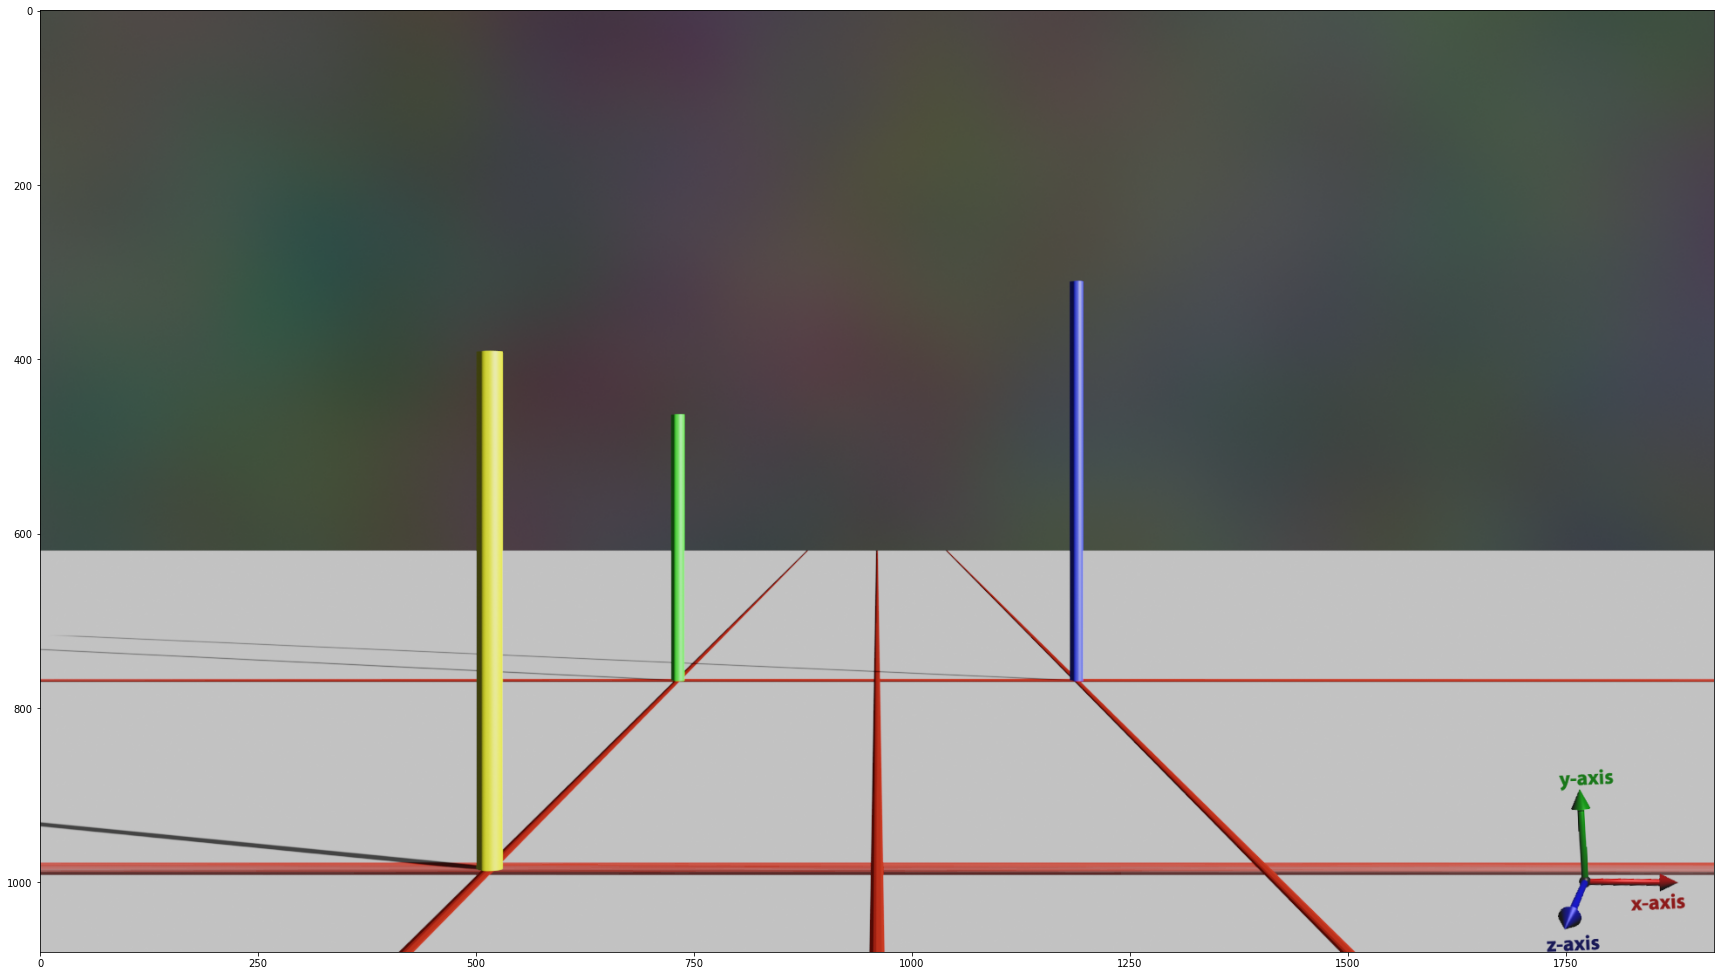

In [85]:
# read in a visualize the image
H_y = 4 # meters
H_g = 4 # meters
H_yg = 17 # meters
pixels_per_meter = 53333
datadir = '/global/home/users/cowherd/cssltimeseries/'
fn  = datadir + 'data/a1-pole-length.png'
im = imageio.imread(fn)
fig,ax=plt.subplots(figsize=(30,30))
ax.imshow(im.astype(int))
plt.show()

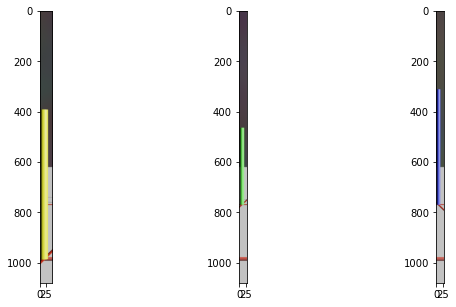

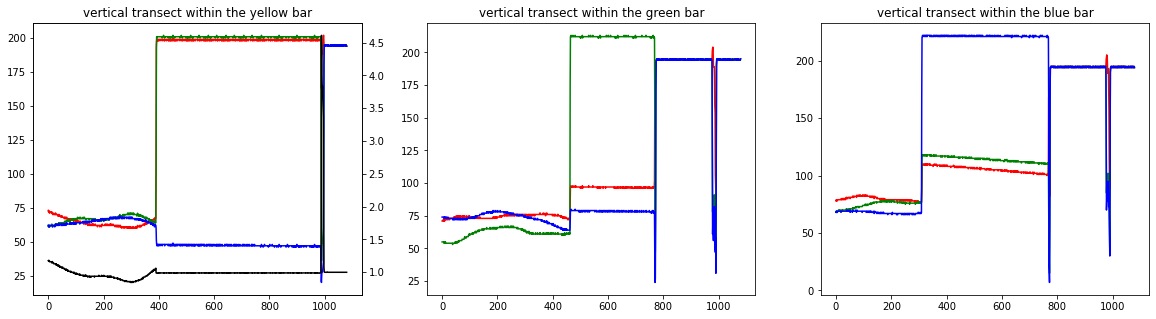

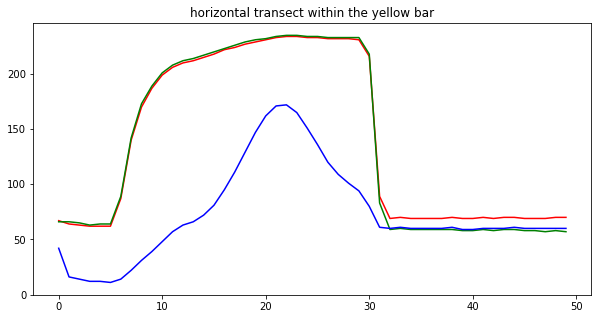

In [68]:
## exploration to correspond patterns in the bands to colors and locations of the bars
## red + green in equal amounts = yellow

yregion= im[:,500:550,:].astype(int)
gregion = im[:,720:750,:].astype(int)
bregion = im[:,1180:1210,:].astype(int)
fig,ax=plt.subplots(1,3,figsize=(10,5))
axs = ax.flatten()
ax[0].imshow(yregion)
ax[1].imshow(gregion)
ax[2].imshow(bregion)
plt.show()

## this is the useful one -- green dropoff is the location of the end of the yellow bar
fig,ax=plt.subplots(1,3, figsize=(20,5))
axs = ax.flatten()
ax2 = axs[0].twinx()
rgratio = yregion[:,10,0]/yregion[:,10,1]
axs[0].plot(yregion[:,10,0], color = 'r')
axs[0].plot(yregion[:,10,1], color = 'g')
axs[0].plot(yregion[:,10,2], color = 'b')
ax2.plot(rgratio,color = 'k')
axs[0].set_title('vertical transect within the yellow bar')
axs[1].plot(gregion[:,10,0], color = 'r')
axs[1].plot(gregion[:,10,1], color = 'g')
axs[1].plot(gregion[:,10,2], color = 'b')
axs[1].set_title('vertical transect within the green bar')
axs[2].plot(bregion[:,10,0], color = 'r')
axs[2].plot(bregion[:,10,1], color = 'g')
axs[2].plot(bregion[:,10,2], color = 'b')
axs[2].set_title('vertical transect within the blue bar')
plt.show()

isyellow = (rgratio > 0.98) & (rgratio < 1.02) & (yregion[:,10,1] > 199)
isgreen = (gregion[:,10,1] > 200)
isblue = (bregion[:,10,2] > 210)

fig,ax=plt.subplots(figsize=(10,5))
ax.plot(yregion[400,:,0], color = 'r')
ax.plot(yregion[400,:,1], color = 'g')
ax.plot(yregion[400,:,2], color = 'b')
ax.set_title('horizontal transect within the yellow bar')
plt.show()


In [86]:
## find locations of the poles in the image and convert to based on pixel density
l_y1 = max(np.where(isyellow)[0])
l_y0 = min(np.where(isyellow)[0])
l_g1 = max(np.where(isgreen)[0])
l_g0 = min(np.where(isgreen)[0])
y_y1 = l_y1 / pixels_per_meter
y_y0 = l_y0 / pixels_per_meter
y_g1 = l_g1 / pixels_per_meter
y_g0 = l_g0 / pixels_per_meter

h_y = (l_y1 - l_y0) / pixels_per_meter  # meters
h_g = (l_g1 - l_g0) / pixels_per_meter  # meters


### set up algebra for focal length 

$Y_{y1} - Y_{y0} = H_y = 4 = H_g$

$\frac{Z_y}{f}* h_y = 4$  and $\frac{Z_y + 17}{f}* h_g = 4$  


$f = \frac{Z_y * h_y}{4}$ and $f = \frac{h_g(Z_y + 17)}{4}$ so

$Z_y = 17h_g / (h_y-h_g)$ 

In [93]:
Z_y = 16*h_g / (h_y - h_g)
f = Z_y * h_y / 4
print('f = ' +str(round(f,5)) + ' m')
print('f = ' +str(round(f*1000,5)) + ' mm')

f = 0.04678 m
f = 46.78368 mm


## the 3D height (Y) of the blue pole, in m
From the previous part, we know the Z location of the yellow bar, which we can use to find the Z location of the green bar (and therefore the blue bar). We know the focal length, so we can use the same technique as before to find the locaiton of the bar in the image and then apply the perspective equation in the y-axis to solve for $Y_b1$ and $Y_b0$:

$Y_{b1} = \frac{Z_by_{b1}}{f}$

$Y_{b0} = \frac{Z_by_{b0}}{f}$ 

$H_b = Y_{b1} - Y_{b0}$

which we can then independently compare with the green bar since they have the same Z-axis location and are the same X distance from the focal plane:

$H_b  = H_g \frac{h_b}{h_g}$

In [94]:
l_b1 = max(np.where(isblue)[0])
l_b0 = min(np.where(isblue)[0])
y_b1 = l_b1 / pixels_per_meter
y_b0 = l_b0 / pixels_per_meter
h_b = (l_b1 - l_b0) / pixels_per_meter  # meters


Z_b = Z_y + 17
Y_b1 = Z_b * y_b1 / f
Y_b0 = Z_b * y_b0 / f
H_b = Y_b1 - Y_b0

H_b2 = H_g * h_b / h_g

print('Blue bar is ' + str(round(H_b,5)) + ' meters from method 1')
print('Blue bar is ' + str(round(H_b2,5)) + ' meters from method 2')

Blue bar is 6.19632 meters from method 1
Blue bar is 6.01316 meters from method 2


# Problem 2
dolly problem -- most code imported from starter code doc. get_projection_matrix() written for assignment.

In [107]:
import copy
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from math import sin, cos

In [96]:
# scene parameters
f_start    = 0.3 # the focal length f to start
grid_count = 20 # the number of squares in one dimension of the plane
Z_start    = 100 # the starting distance between the camera and the cube
Z_end      = 40 # the last distance between camera and the cube
steps      = 30 # number of dolly zoom steps to take between Z_start and Z_end

Getting the projection matrix involves construction matrices from the camera and operation parameters to appropriately transform the image. This feeds into the loop that conducts successive reprojections using $p = \lambda KMP$:

$$
\begin{pmatrix} x_s \\ y_s \\ s \end{pmatrix} = \lambda \begin{pmatrix} f & 0 & c_x \\ 0 & f & c_y \\ 0 & 0 & 1 \end{pmatrix} \begin{pmatrix} r_{11} & r_{21} & r_{31} & t_X \\ r_{12} & r_{22} & r_{32} & t_Y  \\ r_{13} & r_{23} & r_{33} & t_Z \end{pmatrix} \begin{pmatrix} X_w \\ Y_w \\ Z_w \\ 1 \end{pmatrix} 
$$

The function written below 

In [108]:
# WRITE THIS FUNCTION -- EVERYTHING ELSE IS SUPPLIED
#
# build extrinsic (M) and intrinsic (K) matrix and return their product K @ M, a 3 x 4 transformation matrix
# in_trans is a 1D array containing the rotation Rx,Ry,RZ (in degrees), and translation Tx,Ty,Tz
# f is the camera focal length
# transformation matrix should be a numpy matrix of size 3 x 4
def get_projective_matrix(in_trns, f):
    Rx = np.radians(in_trns[0])
    Ry = np.radians(in_trns[1])
    Rz = np.radians(in_trns[2])
    Tx = in_trns[3]
    Ty = in_trns[4]
    Tz = in_trns[5]
    K = np.array([[f,0,0],[0,f,0],[0,0,1]])  # intrinsic
    RMx = np.array([[1,0,0],[0,cos(Rx),-sin(Rx)],[0,sin(Rx),cos(Rx)]])
    RMy = np.array([[cos(Ry),0,sin(Ry)],[0,1,0],[-sin(Ry),0,cos(Ry)]])
    RMz = np.array([[cos(Rz),-sin(Rz),0],[sin(Rz), cos(Rz),0],[0,0,1]])
    RM = RMz @ RMy @ RMx
    M = np.zeros((3,4))
    M[0,3] = Tx
    M[1,3] = Ty
    M[2,3] = Tz
    M[0:3,0:3] = RM    
    return K@M ## return just M instead to keep background the same and make the cube bigger

In [98]:
# return the set of points on a plane in a grid form. 
# every row consist of four points which are corners of each grid square.
# Input: the number of grids in each dimension
# Output: the Nx4 matrix with 3D homogenous points for each square on the plane
def get_plane_mesh(in_plane, grid_n):
    # the two edges of the square
    X = np.linspace(in_plane[0, 0], in_plane[1, 0], grid_n)
    Y = np.linspace(in_plane[1, 1], in_plane[2, 1], grid_n)
    U,V = np.meshgrid(X, Y)
    
    out = np.concatenate((U[:,:,np.newaxis], V[:,:,np.newaxis], 
                          np.zeros_like(U)[:,:,np.newaxis],
                          np.ones_like(U)[:,:,np.newaxis]), axis=2)
    return out

In [99]:
# transform the object using its transform parameters and then project it on the sensor: f=focal length
def transform_points(in_obj, f):
    
    out_obj = dict(in_obj)
    
    XYZ = in_obj['points'].copy()
    in_trns = in_obj['transform'].copy()
    
    # perspective projection
    M = get_projective_matrix(in_trns, f)
    
    p = M @ np.transpose(XYZ) # projection (homogenous coordinates)
    x = p[0,:]/p[2,:] # convert to non-homogenous coordinates
    y = p[1,:]/p[2,:] #
    
    # put the sensor points in the out scene
    out_obj['points'] = np.hstack((x[:, np.newaxis], y[:, np.newaxis]))
    
    return out_obj

In [100]:
# draw the single plane points
def draw_plane(in_ax, in_pts):
    
    c = 0
    for i in range(in_pts.shape[0]-1):
        for j in range(in_pts.shape[1]-1):
            if c%2 == 0:
                in_ax.fill([in_pts[i,j,0], in_pts[i+1,j,0], in_pts[i+1,j+1,0], in_pts[i,j+1,0]],
                           [in_pts[i,j,1], in_pts[i+1,j,1], in_pts[i+1,j+1,1], in_pts[i,j+1,1]], 'k-')
            else:
                in_ax.fill([in_pts[i,j,0], in_pts[i+1,j,0], in_pts[i+1,j+1,0], in_pts[i,j+1,0]],
                           [in_pts[i,j,1], in_pts[i+1,j,1], in_pts[i+1,j+1,1], in_pts[i,j+1,1]], 'w-')
            c = c + 1
            
# given one scene in a scene dictionary, visualize the scene 
def visualize_scene(in_scene):
    
    # draw
    my_dpi = 96
    fig = plt.figure(figsize=(800/my_dpi, 400/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot()
    
    # plot the ground plane
    xy = in_scene['ground_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the right plane
    xy = in_scene['right_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the left plane
    xy = in_scene['left_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the back plane
    xy = in_scene['back_plane']['points']
    cur_proj = np.concatenate((np.reshape(xy[:,0], (grid_count, grid_count, 1)), 
                               np.reshape(xy[:,1], (grid_count, grid_count, 1))), axis=2)
    draw_plane(ax, cur_proj)

    # plot the cube
    xy = in_scene['cube']['points']
    x = xy[:,0].copy()
    y = xy[:,1].copy()

    # draw six faces of the cube
    plt.fill([x[0],x[1],x[2],x[3]],[y[0],y[1],y[2],y[3]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[4],x[5],x[6],x[7]],[y[4],y[5],y[6],y[7]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[0],x[1],x[5],x[4]],[y[0],y[1],y[5],y[4]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[1],x[2],x[6],x[5]],[y[1],y[2],y[6],y[5]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[2],x[3],x[7],x[6]],[y[2],y[3],y[7],y[6]],color=[0.7,0.7,0.7,0.5])
    plt.fill([x[3],x[0],x[4],x[7]],[y[3],y[0],y[4],y[7]],color=[0.7,0.7,0.7,0.5])

    # draw six edges of the cube
    plt.plot([x[0],x[1]],[y[0],y[1]],'ro-')
    plt.plot([x[1],x[2]],[y[1],y[2]],'ro-')
    plt.plot([x[2],x[3]],[y[2],y[3]],'ro-')
    plt.plot([x[3],x[0]],[y[3],y[0]],'ro-')

    plt.plot([x[4],x[5]],[y[4],y[5]],'ro-')
    plt.plot([x[5],x[6]],[y[5],y[6]],'ro-')
    plt.plot([x[6],x[7]],[y[6],y[7]],'ro-')
    plt.plot([x[7],x[4]],[y[7],y[4]],'ro-')

    plt.plot([x[0],x[4]],[y[0],y[4]],'ro-')
    plt.plot([x[1],x[5]],[y[1],y[5]],'ro-')
    plt.plot([x[2],x[6]],[y[2],y[6]],'ro-')
    plt.plot([x[3],x[7]],[y[3],y[7]],'ro-')

    ax.set_aspect('equal', adjustable='box')
    plt.xlim([-0.2, 0.2])
    plt.ylim([-0.1, 0.1])
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.draw()
    plt.tight_layout()
    
    # save the current plot and return this image
    plt.savefig('temp.png', dpi=my_dpi)
    image = imageio.imread('temp.png')
    os.remove('temp.png')
    return image

In [101]:
# scene dictionary has keys as object names, each object key will store object transformation and object points

# 3-D, unit-cube (homogenous coordinates)
cube = np.array([[0,0,0,1],[1,0,0,1],[1,1,0,1],[0,1,0,1],
              [0,0,1,1],[1,0,1,1],[1,1,1,1],[0,1,1,1]])

# make length of the cube 12 meters
cube[:, :3] = 12*cube[:, :3]
cube[:, :3] = cube[:, :3] - 6

height = 400 # height of the walls
plane = np.array([[0,0,0,1],[height,0,0,1],[height,height,0,1],[0,height,0,1]])

# create an empty scene
scene = {}
scene['ground_plane'] = {}
scene['right_plane'] = {}
scene['left_plane'] = {}
scene['back_plane'] = {}
scene['cube'] = {}

# put the points and transformation (Rx, Ry, Rz, Tx, Ty, Tz)
scene['ground_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['ground_plane']['transform'] = np.array([90, 0, 0,-height/2, -30, Z_start])

scene['right_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['right_plane']['transform'] = np.array([0, -90, 0, height/2, -30, Z_start])

scene['left_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['left_plane']['transform'] = np.array([0, -90, 0, -height/2, -30, Z_start])

scene['back_plane']['points'] = np.reshape(get_plane_mesh(plane, grid_count), (-1, 4))
scene['back_plane']['transform'] = np.array([0, 0, 0, -height/2, -30, height+Z_start])

scene['cube']['points'] = cube
scene['cube']['transform'] = np.array([30,30,0,0,0, Z_start])

/tmp/ipykernel_196/3722046249.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(800/my_dpi, 400/my_dpi), dpi=my_dpi)


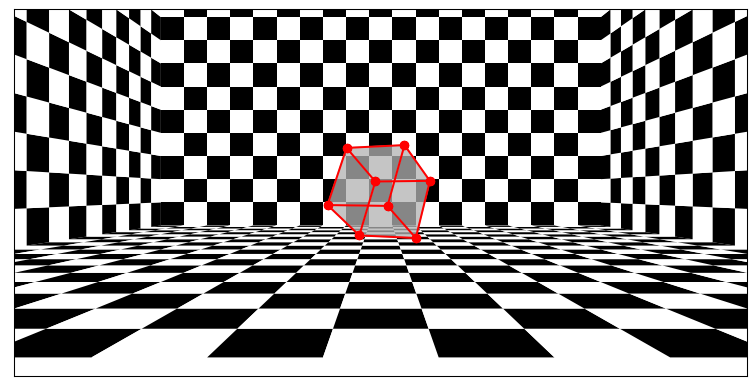

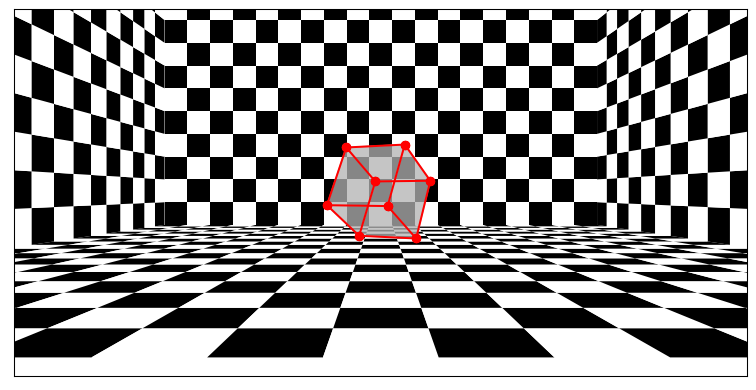

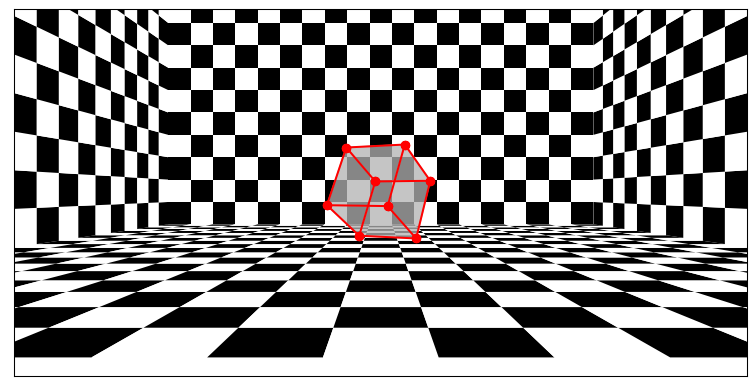

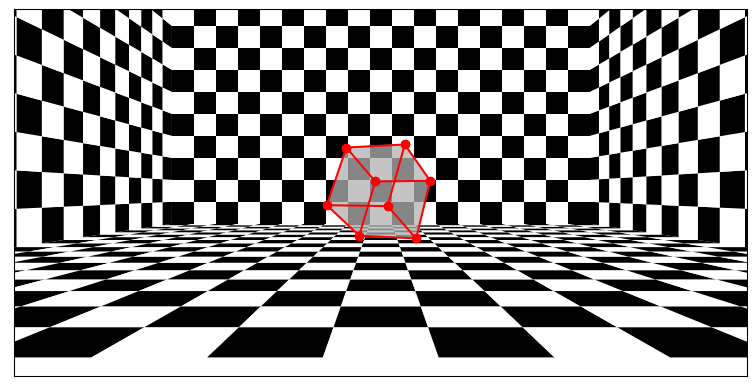

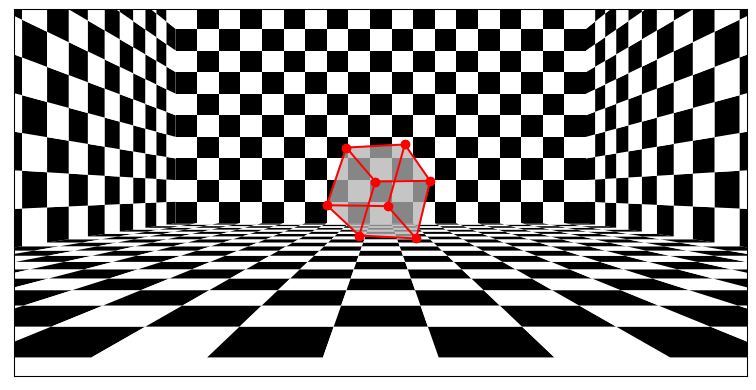

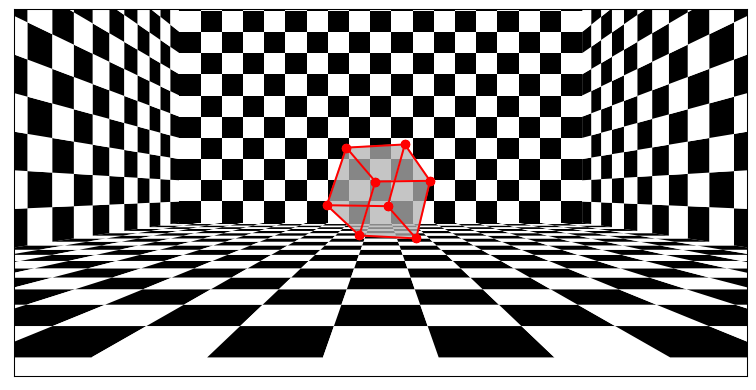

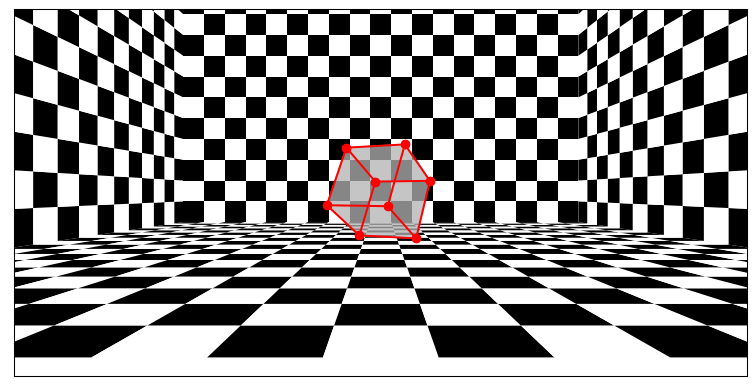

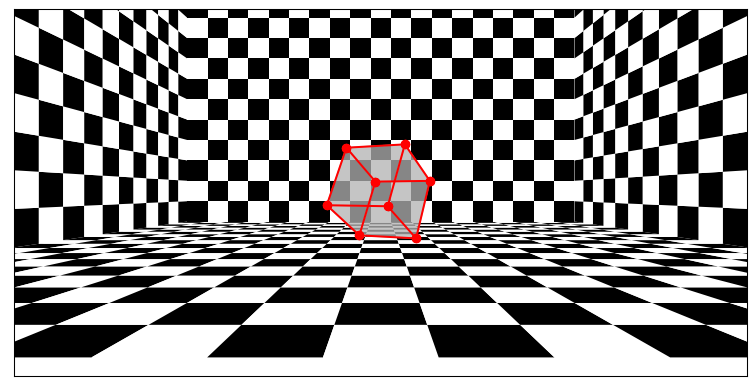

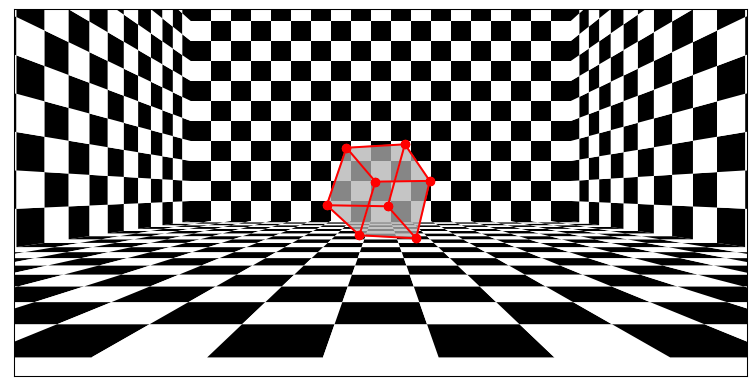

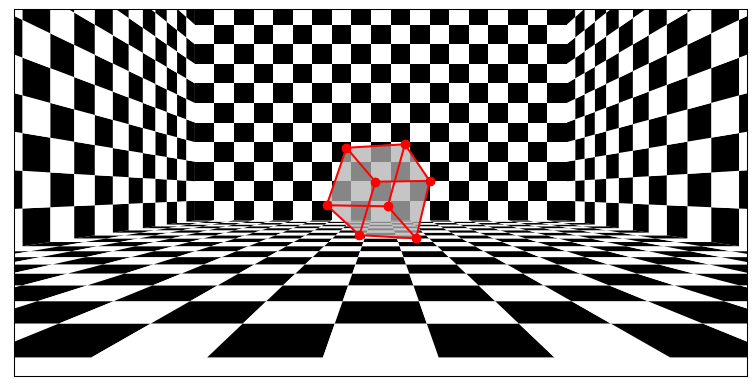

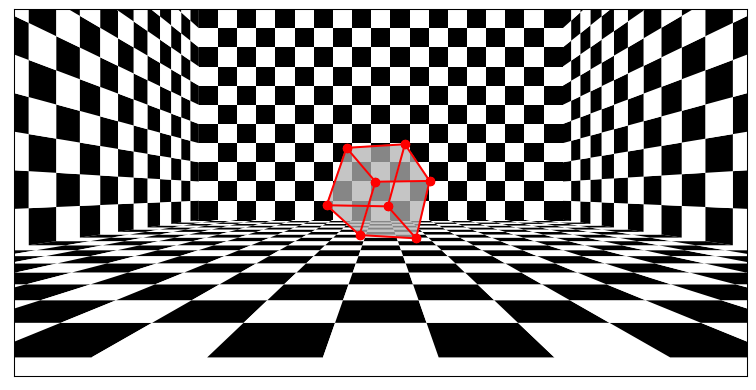

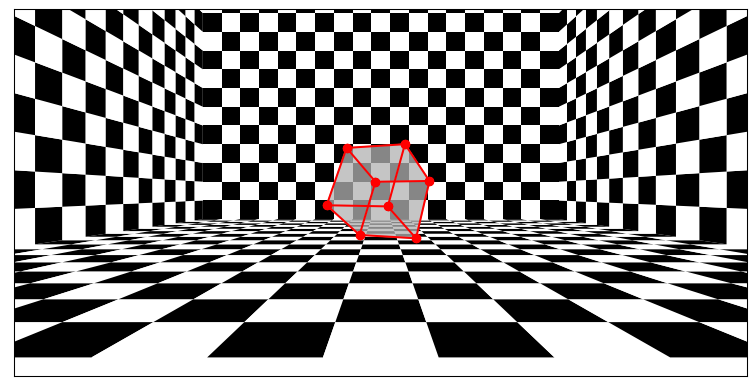

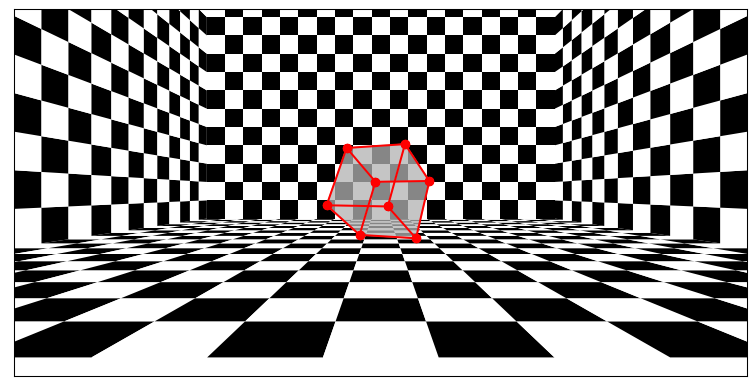

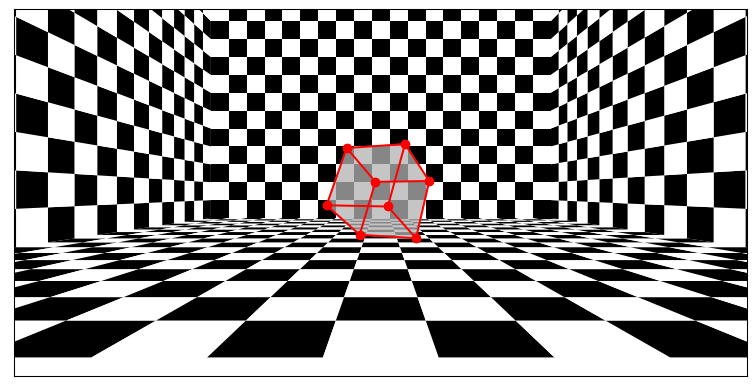

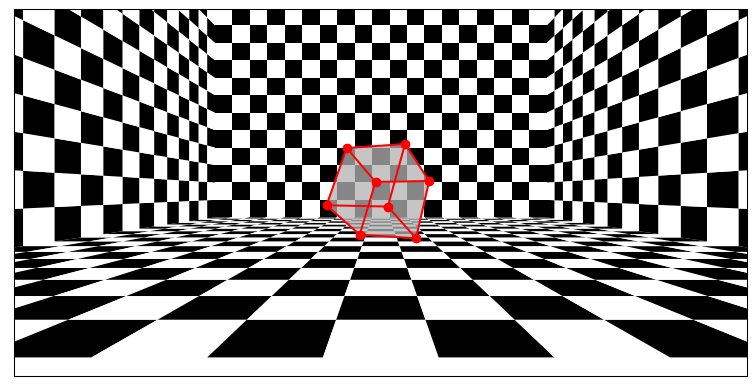

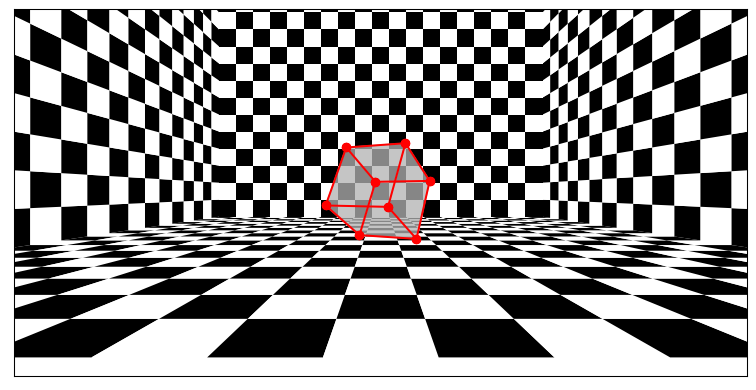

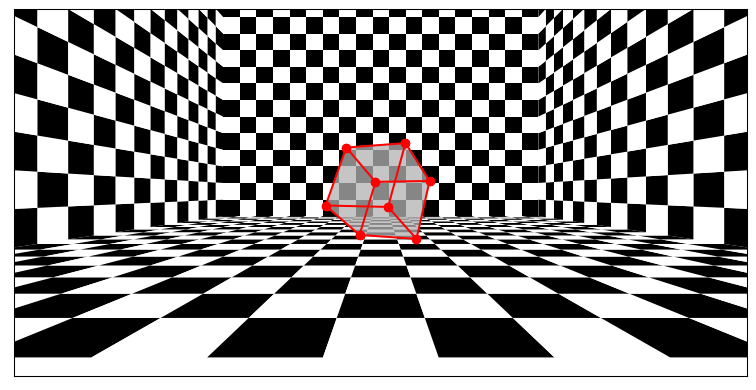

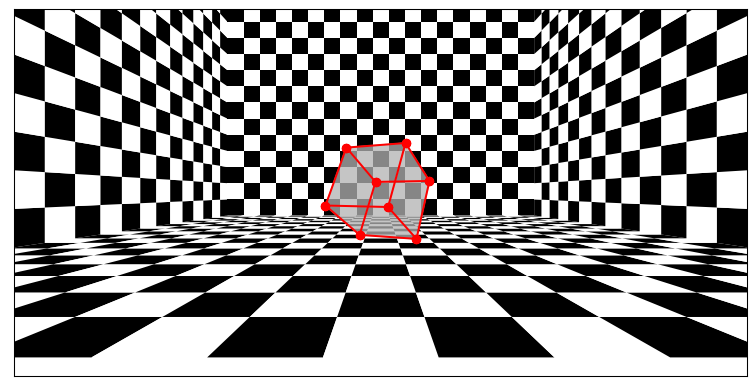

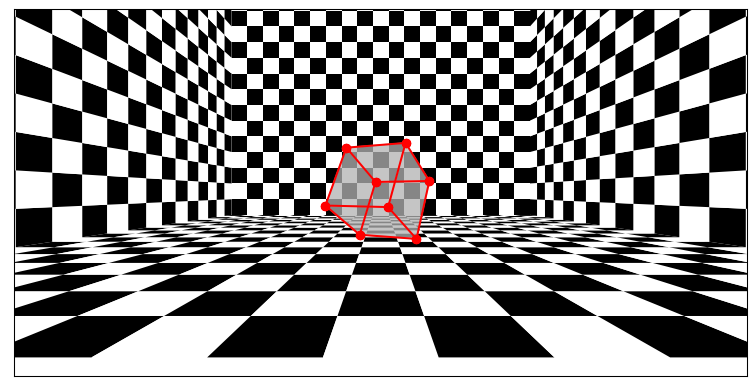

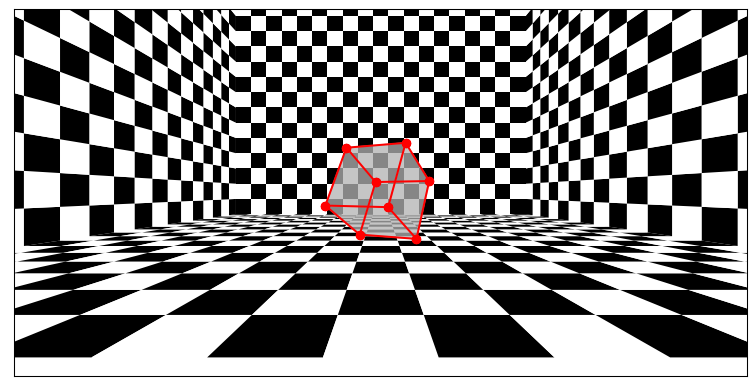

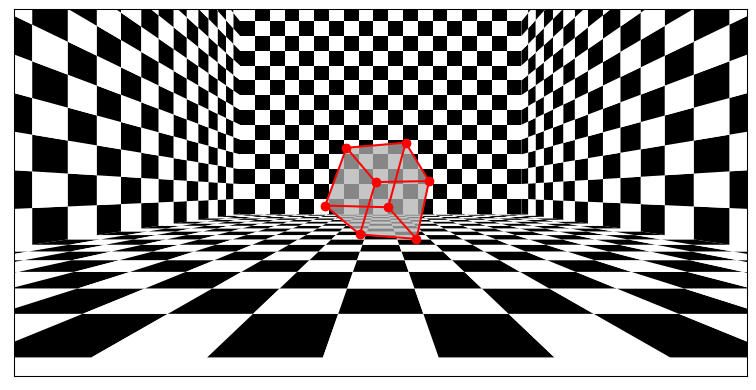

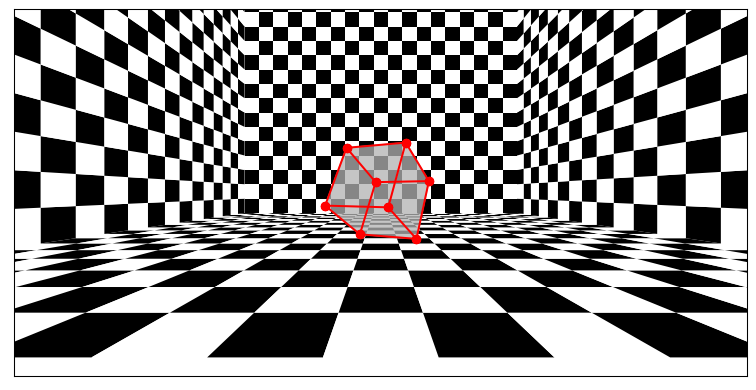

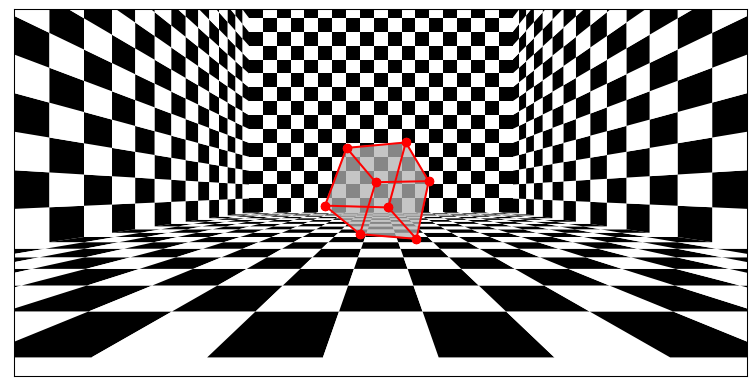

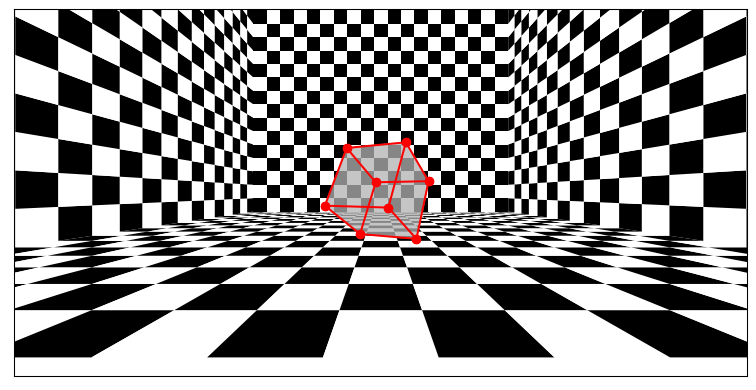

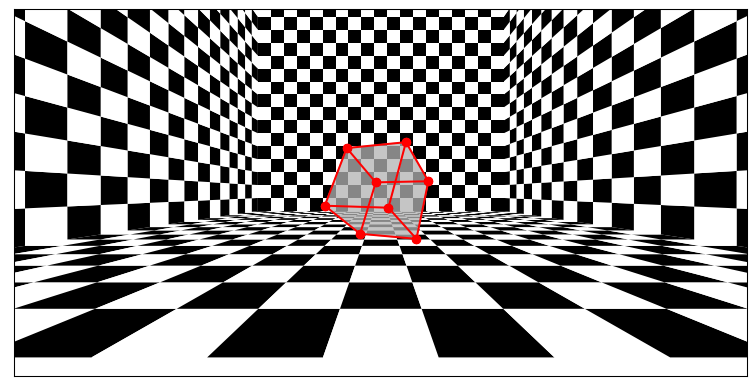

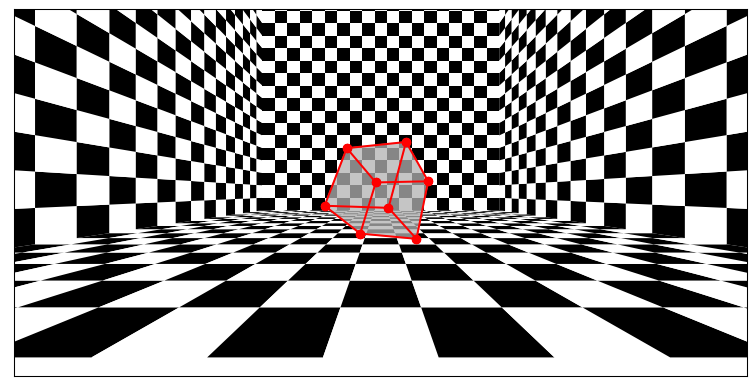

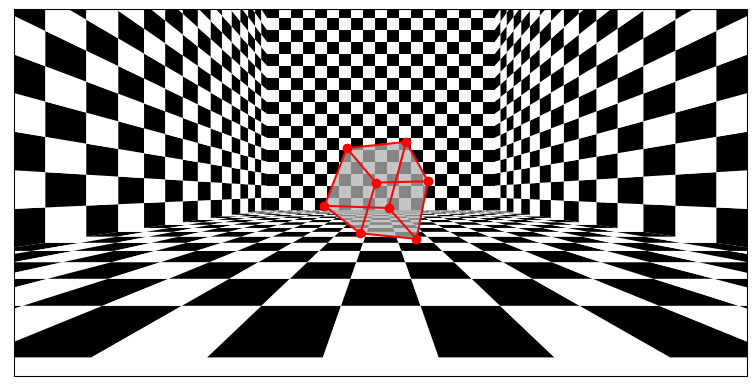

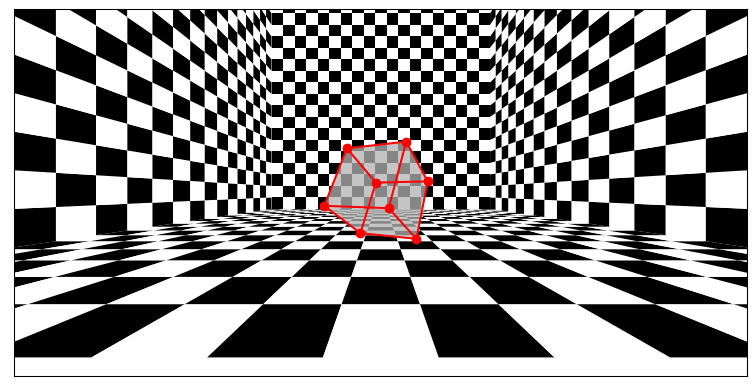

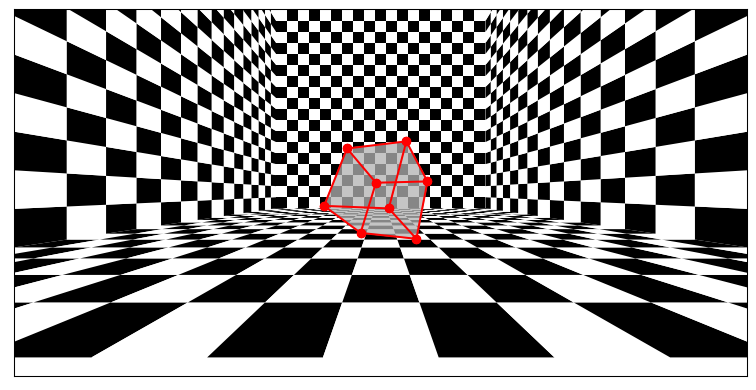

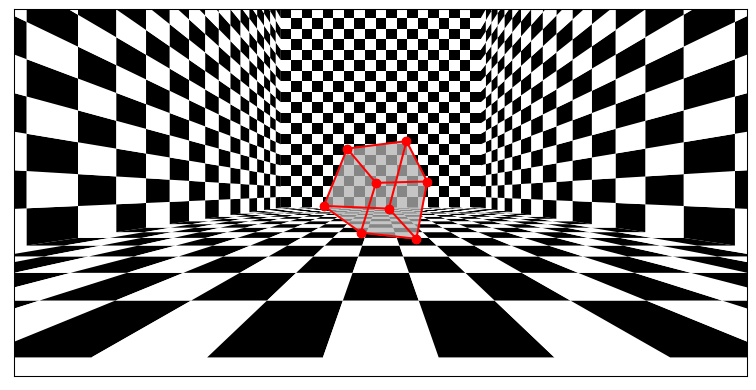

In [109]:
# perform dolly zoom of the entire scene and save as a gif

# these are the z-movement of the scene for dolly
Tzs = np.linspace(Z_start, Z_end, steps)
fs = f_start*Tzs/Z_start

# initialize the animation file
gif_writer = imageio.get_writer('output.gif', mode='I')

# update the scene and generate images
for i in range(steps):
    
    projected_scene = {}
    for k in scene.keys(): # iterate over the objects
        
        # current object in the scene
        cur_obj = copy.deepcopy(scene[k])
        
        # modify the Z-values of the current object in the new_scene
        cur_obj['transform'][-1] = cur_obj['transform'][-1] + (Tzs[i]-Z_start)
        
        # project this objects on the sensor
        projected_scene[k] = transform_points(cur_obj, fs[i])
        
    # visualize the scene
    plot_img = visualize_scene(projected_scene)
    
    # write the current image in the gif
    gif_writer.append_data(plot_img)
    
gif_writer.close()